In [ ]:
# Install PyTorch Geometric and dependencies
import torch

# Check PyTorch version
print(torch.__version__)


# For CPU version
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cpu.html


2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 649.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00


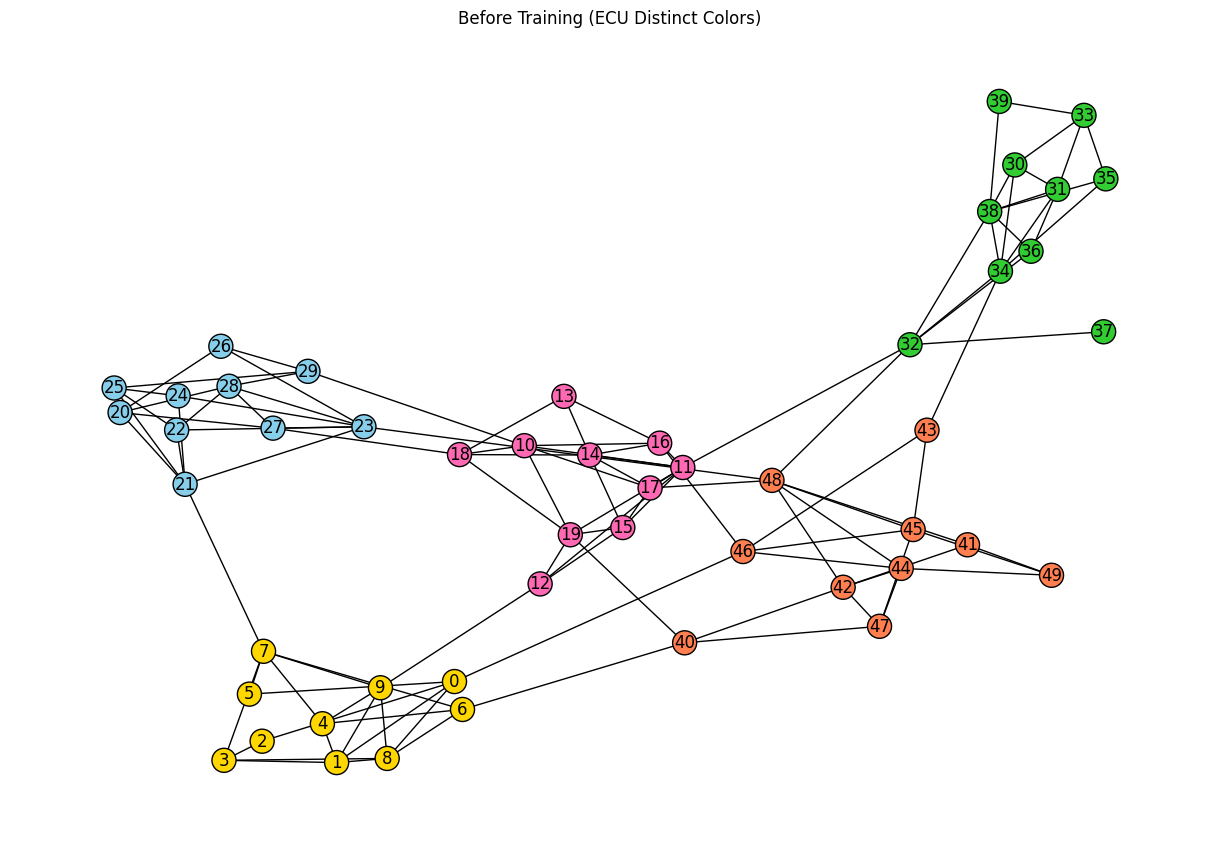

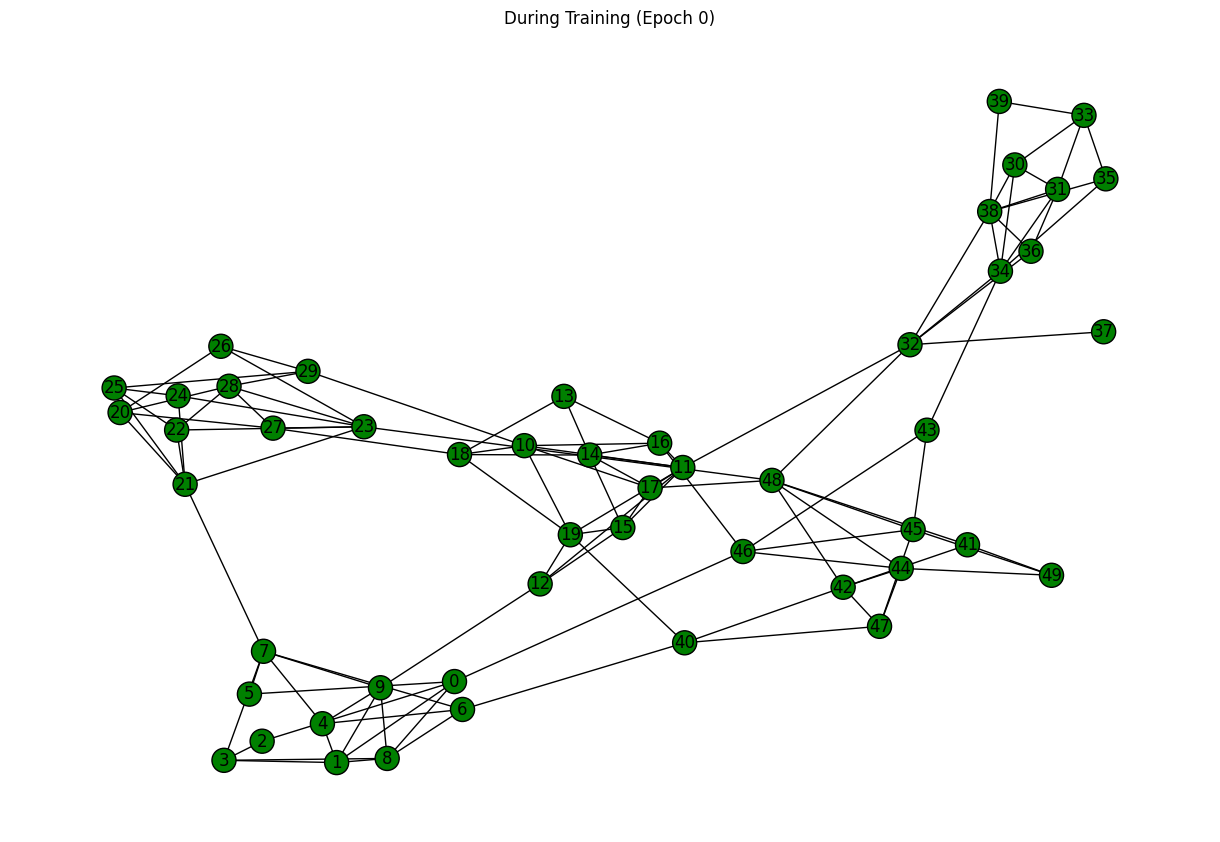

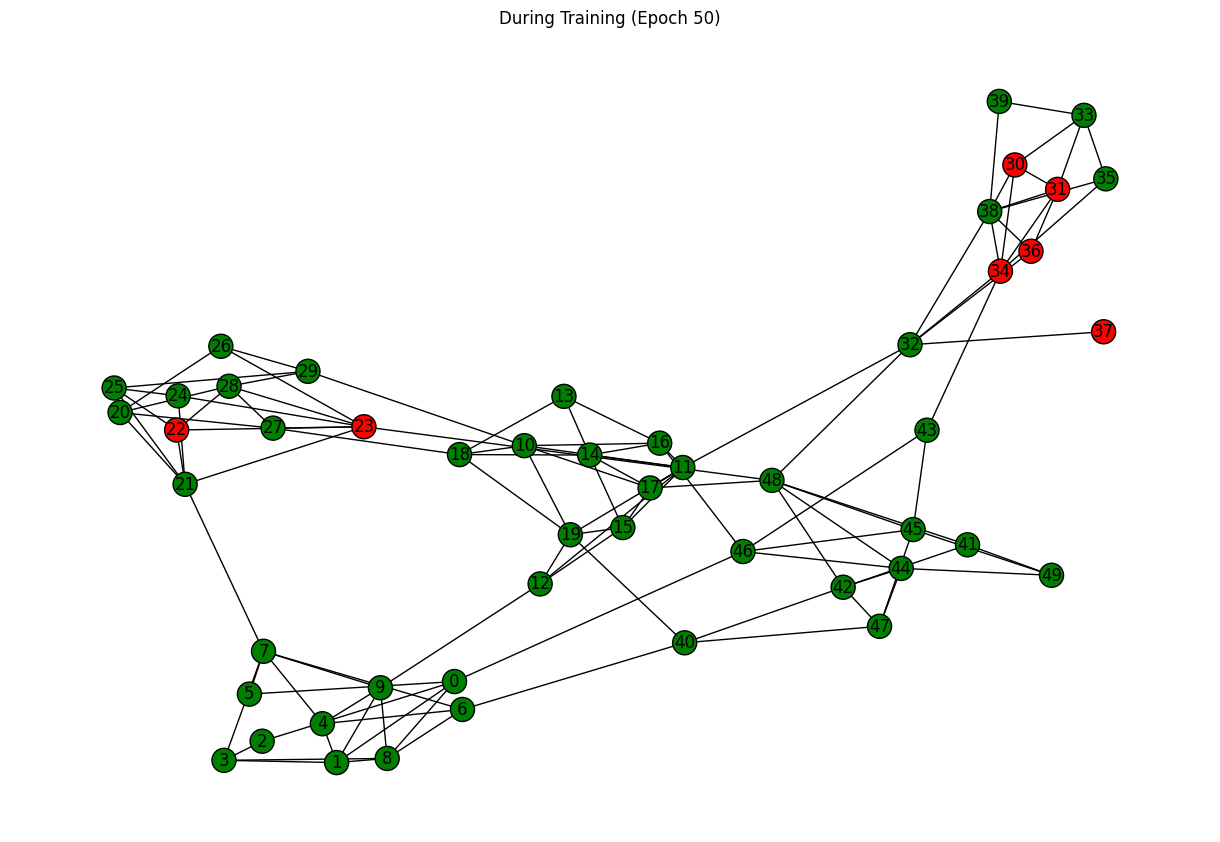

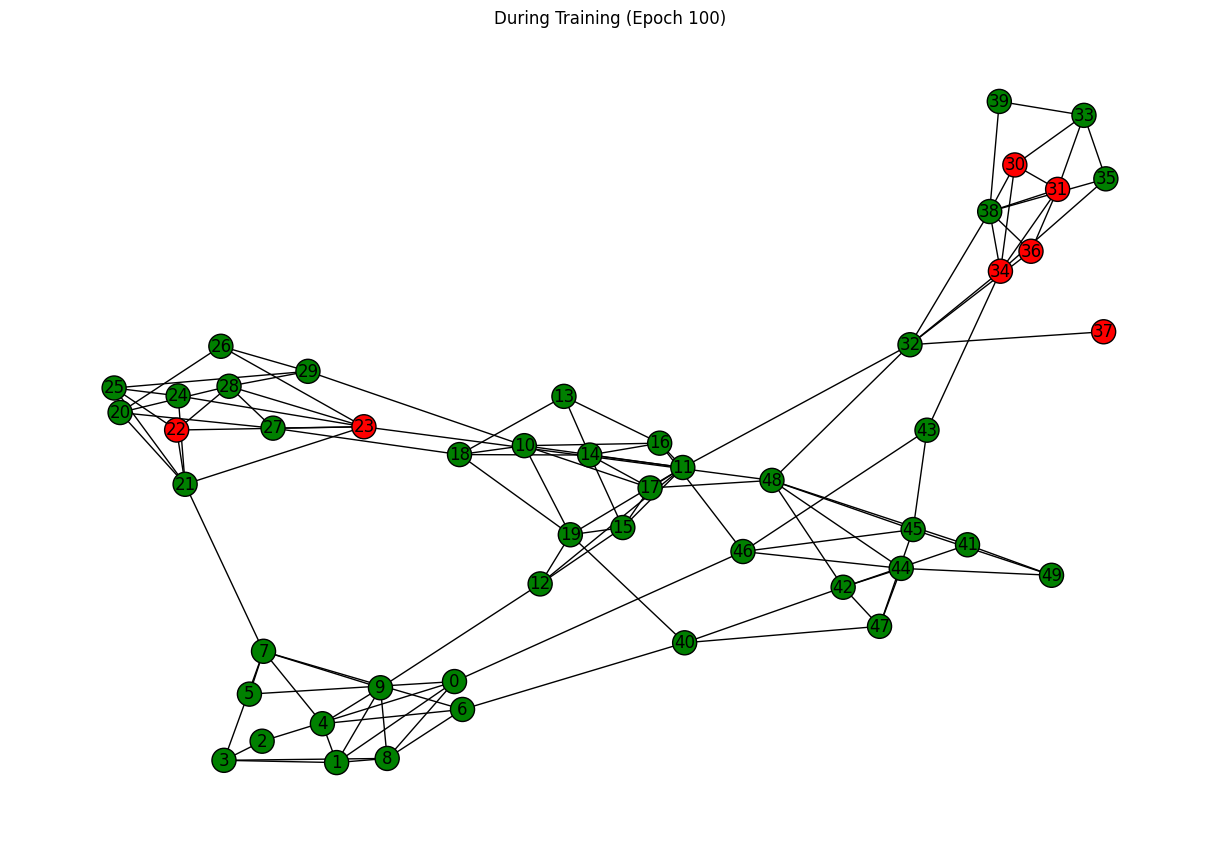

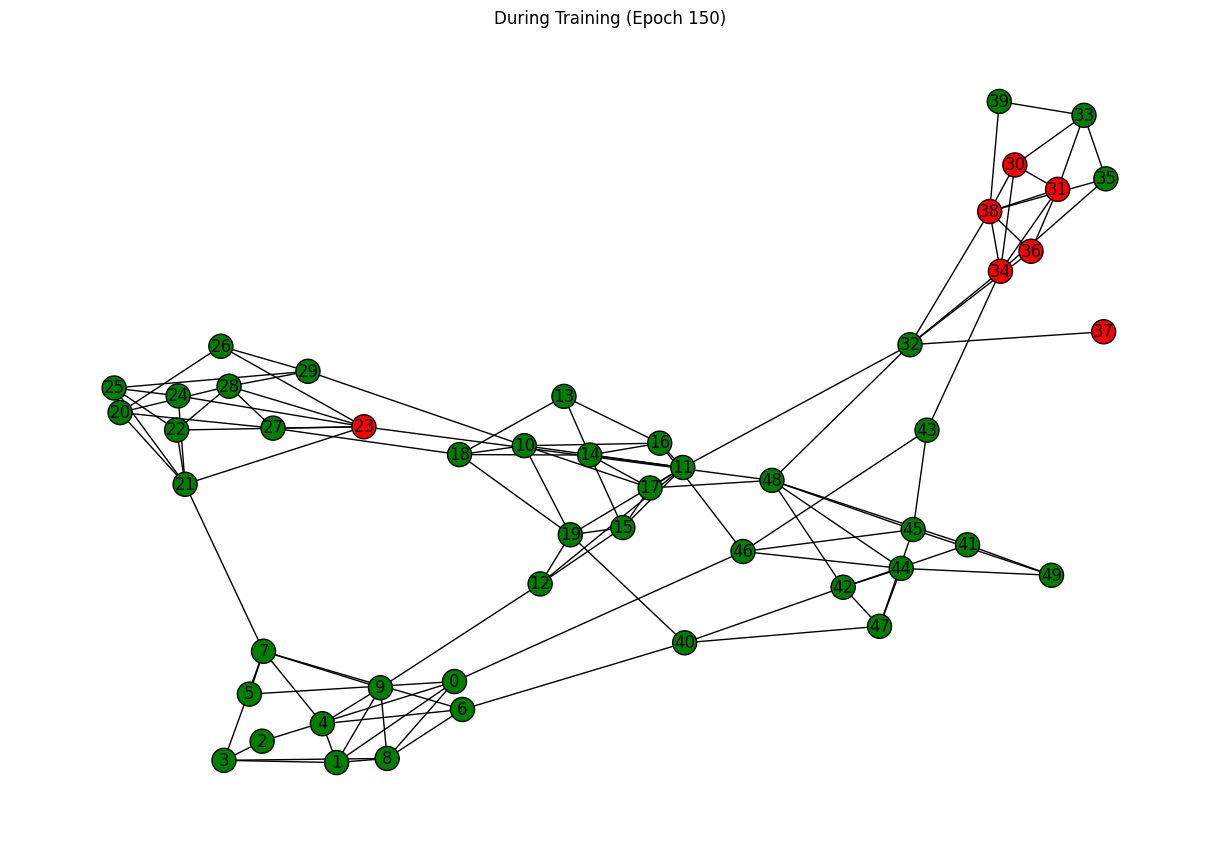

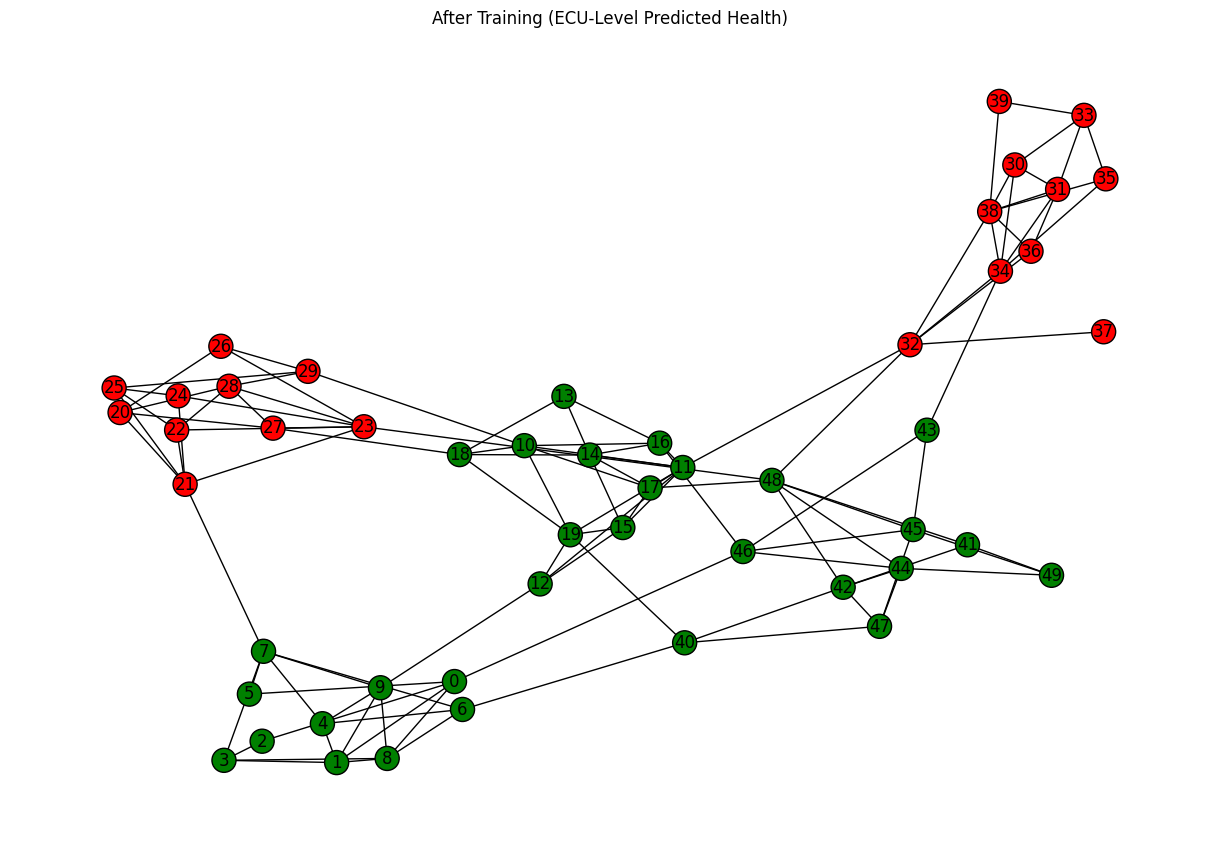


Epoch-wise Loss:

Epoch 0: Loss = 3.773800
Epoch 10: Loss = 0.944501
Epoch 20: Loss = 0.455182
Epoch 30: Loss = 0.514556
Epoch 40: Loss = 0.449488
Epoch 50: Loss = 0.429326
Epoch 60: Loss = 0.411770
Epoch 70: Loss = 0.391401
Epoch 80: Loss = 0.387409
Epoch 90: Loss = 0.386339
Epoch 100: Loss = 0.385032
Epoch 110: Loss = 0.383972
Epoch 120: Loss = 0.383036
Epoch 130: Loss = 0.382254
Epoch 140: Loss = 0.381578
Epoch 150: Loss = 0.381013
Epoch 160: Loss = 0.380545
Epoch 170: Loss = 0.380161
Epoch 180: Loss = 0.379846
Epoch 190: Loss = 0.379584


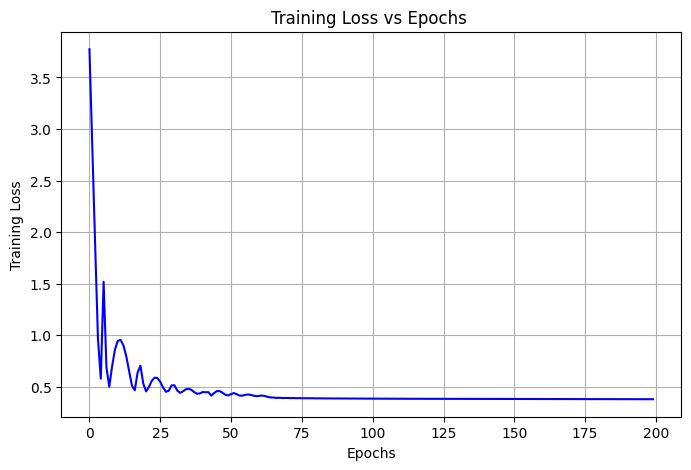


ECU Health Status (After Training):

ECU 1: True = Faulty, Predicted = Healthy
ECU 2: True = Faulty, Predicted = Healthy
ECU 3: True = Faulty, Predicted = Faulty
ECU 4: True = Faulty, Predicted = Faulty
ECU 5: True = Faulty, Predicted = Healthy


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# --- Step 1: Define ECU and Sensors ---
num_ecus = 5
sensors_per_ecu = 10
total_sensors = num_ecus * sensors_per_ecu

sensor_to_ecu = []
features = []
labels = []

for ecu in range(num_ecus):
    for sensor in range(sensors_per_ecu):
        sensor_to_ecu.append(ecu)
        if random.random() < 0.7:
            features.append([np.random.uniform(50, 100), np.random.uniform(0, 1)])
            labels.append(0)  # Healthy
        else:
            features.append([np.random.uniform(0, 10), np.random.uniform(0, 1)])
            labels.append(1)  # Faulty

features = np.array(features)
labels = np.array(labels)
sensor_to_ecu = np.array(sensor_to_ecu)

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

# --- Step 2: Create Graph Connections ---
edges = []
for ecu in range(num_ecus):
    sensors = np.where(sensor_to_ecu == ecu)[0]
    for i in sensors:
        neighbors = np.random.choice(sensors, size=random.randint(2, 3), replace=False)
        for n in neighbors:
            if i != n:
                edges.append((i, n))

# Add random cross-ECU connections
for _ in range(15):
    s1, s2 = random.sample(range(total_sensors), 2)
    edges.append((s1, s2))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

data = Data(x=x, edge_index=edge_index, y=y)

# --- Step 3: GCN Model ---
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(2, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        self.embeddings = x.detach()
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# --- Step 4: Plotting Function ---
def plot_graph(preds, title, mode='training'):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())

    ecu_colors_distinct = ['gold', 'hotpink', 'skyblue', 'limegreen', 'coral']
    node_colors = []

    if mode == 'before':
        for i in range(total_sensors):
            ecu_id = sensor_to_ecu[i]
            node_colors.append(ecu_colors_distinct[ecu_id])
    elif mode == 'intermediate':
        for i in range(total_sensors):
            color = 'red' if preds[i] == 1 else 'green'
            node_colors.append(color)
    else:  # After Training ECU-wise aggregation
        ecu_health = []
        for ecu in range(num_ecus):
            ecu_sensors = np.where(sensor_to_ecu == ecu)[0]
            ecu_faulty = np.any(preds[ecu_sensors] == 1)
            ecu_health.append(1 if ecu_faulty else 0)  # 1: Faulty, 0: Healthy

        for i in range(total_sensors):
            ecu_id = sensor_to_ecu[i]
            color = 'red' if ecu_health[ecu_id] == 1 else 'green'
            node_colors.append(color)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=300, edgecolors='black')
    plt.title(title)
    plt.show()

# --- Step 5: Before Training (Distinct ECU Colors) ---
plot_graph(labels, "Before Training (ECU Distinct Colors)", mode='before')

# --- Step 6: Training ---
epochs = 200
loss_values = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())

    if epoch in [0, 50, 100, 150]:  # Plot intermediate
        model.eval()
        preds = model(data).argmax(dim=1).numpy()
        plot_graph(preds, f"During Training (Epoch {epoch})", mode='intermediate')

# --- Step 7: After Training (Final ECU Grouping) ---
model.eval()
final_preds = model(data).argmax(dim=1).numpy()
plot_graph(final_preds, "After Training (ECU-Level Predicted Health)", mode='after')

# --- Step 8: Print All Epochs Loss at Once ---
print("\nEpoch-wise Loss:\n")
for epoch, l in enumerate(loss_values):
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {l:.6f}")

# --- Step 9: Plot Training Loss Curve ---
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), loss_values, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs ')
plt.grid(True)
plt.show()

# --- Step 10: Print ECU Status ---
print("\nECU Health Status (After Training):\n")
for ecu in range(num_ecus):
    ecu_sensors = np.where(sensor_to_ecu == ecu)[0]
    pred_faulty = np.any(final_preds[ecu_sensors] == 1)
    true_faulty = np.any(labels[ecu_sensors] == 1)
    print(f"ECU {ecu+1}: True = {'Faulty' if true_faulty else 'Healthy'}, Predicted = {'Faulty' if pred_faulty else 'Healthy'}")
